# Digitized-counterdiabatic quantum approximate optimization algorithm


In [1]:
from mindquantum import *

import mindspore.nn as nn
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

import matplotlib.pyplot as plt
from scipy.linalg import eigvals
import numpy as np

/opt/anaconda3/envs/mindquantum/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Unable import mqvector gpu backend due to: cannot import name '_mq_vector_gpu' from partially initialized module 'mindquantum' (most likely due to a circular import) (/opt/anaconda3/envs/mindquantum/lib/python3.9/site-packages/mindquantum/__init__.py)
  from .available_simulator import SUPPORTED_SIMULATOR


## Define problem hamiltonian

Here we consider LFIM model, the Hamiltonian is:

$$H_{prob} = -J\sum_{i=1}^{n-1}\sigma^z_i\sigma^z_{i+1}-h\sum_{i=1}^{n}{\sigma_i^z}$$

In [2]:
def generate_h_prob(n_qubits:int, J:float, h:float):
    h_prob = QubitOperator()
    for i in range(n_qubits-1):
        h_prob += QubitOperator(f'Z{i} Z{i+1}', -J)
    for i in range(n_qubits):
        h_prob += QubitOperator(f'Z{i}', -h)
    return h_prob

## Define mixer hamiltonian

The mixer Hamiltonian normally choosed as:

$$H_\text{mixer}=\sum_{i=1}^{n}{\sigma_i^x}$$

In [3]:
def generate_h_mixer(n_qubits:int):
    h_mixer = QubitOperator()
    for i in range(n_qubits):
        h_mixer += QubitOperator(f'X{i}')
    return h_mixer

## Define CD term

For this problem Hamiltonian, CD terms can be genetared and picked up empirically according to nested commutator:

$$H_{cd} = \sum_{i=1}^{n}\sigma_i^y$$

In [4]:
def generate_h_cd(n_qubits:int):
    h_cd = QubitOperator()
    for i in range(n_qubits):
        h_cd += QubitOperator(f'Y{i}')
    return h_cd

## Example: found the ground state energy of given system

Here we choice a 12 qubits system to study. For simplify, we choice $J=1, h=1$.

In [5]:
n_qubits = 12
J, h = 1, 1

h_prob = generate_h_prob(n_qubits, J, h)
h_mixer = generate_h_mixer(n_qubits)
h_cd = generate_h_cd(n_qubits)

## Generate ansatz

The ansatz is the trotterized time evolution of annealing Hamiltonian.

- For $U_p(\gamma)$

In [6]:
u_p = 0
for index,i in enumerate(h_prob):
    u_p += decompose_single_term_time_evolution(i, ParameterResolver(f'c'))

- For $U_m(\beta)$

In [7]:
u_m = 0
for i in h_mixer:
    u_m += decompose_single_term_time_evolution(i, ParameterResolver(f'b'))

- For $U_{CD}$

Her we use $\sigma^z\sigma^y, \sigma^y$ as the CD term.

In [8]:
u_cd = 0
for i in h_cd:
    u_cd += decompose_single_term_time_evolution(i, ParameterResolver(f'a'))

- Initial state

The initial state is the eigen state of mixer Hamiltonian. Here a layer of `X` gate can be used to easily prepare the initial state.

In [9]:
prep_circ = UN(H, n_qubits)

## Construct the circuit

Here we choice $p=1$ to demostrate the performance of DC-QAOA.

In [10]:
from mindquantum.core.gates import BarrierGate
from mindquantum.core.circuit import add_suffix

p = 1

ansatz_template =   u_p + u_m  + u_cd

ansatz = Circuit() + prep_circ

for i in range(p):
    ansatz += add_suffix(ansatz_template, str(i)) + BarrierGate()

#ansatz.svg()

# Optimize

Here we use Adagrad classical optimizer in Mindquantum to optimize the paramters.

In [11]:
def train(ham, ansatze, iteration):

    # bulid the quantum circuit
    
    circ = ansatze                                         # 将初始化线路与ansatz线路组合成一个线路
    sim = Simulator('mqvector', ansatze.n_qubits)  
    
    grad_ops = sim.get_expectation_with_grad(ham, circ)    # 获取计算变分量子线路的期望值和梯度的算子
    net = MQAnsatzOnlyLayer(grad_ops)                             
    opti = nn.Adam(net.trainable_params(), learning_rate=0.05)     
    train_net = nn.TrainOneStepCell(net, opti)                    

    result = []
    #from tqdm import tqdm
    for i in range(iteration):
        train_net() 
        result.append(np.array(train_net()[0]))
    pr = dict(zip(ansatze.params_name, net.weight.asnumpy())) # 获取线路参数
        
    return result

## Calculate the gradient.

MindQuanutm can calculate the gradient very easily. The model here is:

$$E = \left<\psi_0\right|\Pi_{j=0}^1 U_p^\dagger(\gamma_j)U_m^\dagger(\beta_j)U_{cd}^\dagger(\alpha_j) H_{prob} \Pi_{i=0}^1 U_{cd}(\alpha_i)U_m(\beta_i)U_p(\gamma_i)\left|\psi_0\right>$$

In [12]:
ite = 100

ham = Hamiltonian(h_prob)
sim = Simulator('mqvector', n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, ansatz)
result = train(ham, ansatz, ite)

# Build QAOA ansatz for comparasion

In [13]:
prep_circ_qaoa = UN(H, n_qubits)

ansatz_template_qaoa = u_p + u_m 

ansatz_qaoa = Circuit() + prep_circ_qaoa
for i in range(p):
    ansatz_qaoa += add_suffix(ansatz_template_qaoa, str(i)) + BarrierGate()

In [14]:
ham = Hamiltonian(h_prob)
sim = Simulator('mqvector', n_qubits)
grad_ops = sim.get_expectation_with_grad(ham, ansatz_qaoa)
result_qaoa = train(ham, ansatz_qaoa, ite)

## Theoretical result

In [15]:
mat = h_prob.matrix().toarray()
e_v = eigvals(mat)

ground_state_energy = np.min(np.real(e_v))
print('Theoretic ground state energy is: ', ground_state_energy)

Theoretic ground state energy is:  -23.0


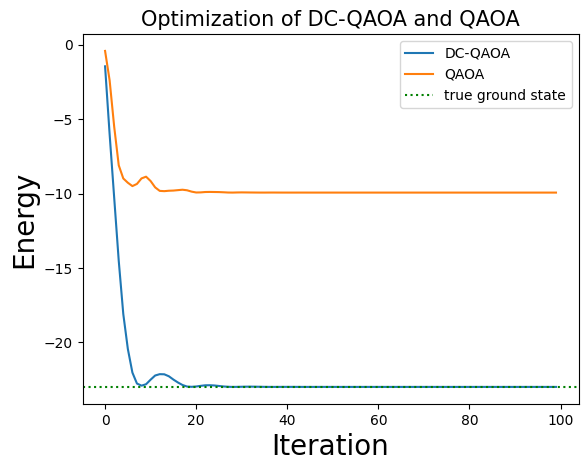

In [25]:
plt.plot(result,label="DC-QAOA")
plt.plot(result_qaoa,label="QAOA")
plt.xlabel('Iteration', fontsize=20)
plt.ylabel('Energy', fontsize=20)
plt.axhline(ground_state_energy,color='g',linestyle=':',label="true ground state")
plt.title("Optimization of DC-QAOA and QAOA", fontsize=15)
plt.legend()
plt.savefig('DC-QAOA.png',dpi=300,bbox_inches='tight')